# Wikipedia Statistics #

## Table of Content ##

&nbsp;1. [Introduction](#1.-Introduction)  
&nbsp;2. [Code](#2.-Code)  
&nbsp;3. [The Results](#3.-The-Results)  

&nbsp;&nbsp;3.1. [The English Wikipedia](#3.1.-English-Wikipedia)  
&nbsp;&nbsp;&nbsp;3.1.1. [Longest Path](#3.1.1.-Longest-Path)  

&nbsp;&nbsp;3.2. [The Swedish Wikipedia](#3.2.-Swedish-Wikipedia)  
&nbsp;&nbsp;&nbsp;3.2.1. [Longest Path](#3.2.1.-Longest-Path)  

&nbsp;&nbsp;3.3. [The German Wikipedia](#3.3.-German-Wikipedia)  
&nbsp;&nbsp;&nbsp;3.3.1. [Longest Path](#3.3.1.-Longest-Path)  

&nbsp;&nbsp;3.4. [The Frensh Wikipedia](#3.4.-Frensh-Wikipedia)  
&nbsp;&nbsp;&nbsp;3.4.1. [Longest Path](#3.4.1.-Longest-Path)  



## 1. Introduction ##

This page contains some interesting statistics about paths between two articles on wikipedia. A _path_ is defined as a set of articles that can be reached from one another using only the links on thoes paths. The links are also not alowed to link outside of the main wikipedia (i.e. Talk pages and Caterory pages are not allowed). The data gathered is the result of paths between two randomly selected articles. The result is then stored in a postgresql database and retrieved in python using the `psycopg2` library. All the paths where generated by a python program. The project can be found [here on my github page]( https://github.com/exal99/wikipedia-analysis).


## 2. Code ##

This section will describe all code used to generate the resulting graphs. If you are just interested in the result feel free to skip right ahead to the [results](#The-Results). As mention before I will be using `psycopg2` to retrive all the data from my postgresql server running localy on my computer.

In [1]:
import psycopg2

[usr_name, password] = open('pass.txt').readlines()[0].split(' ')

def get_cursor(lang):
    """
    Gets the sql cursor for the database with the given language code.
    
    Args:
    lang - The language code for the database
    """
    connection = psycopg2.connect(dbname=lang+'wikidb', user=usr_name, password=password)
    return connection.cursor()

To make a histogram over all the paths lenght and their relative frequensy, all paths are retived and counted in groups of same length using some SQL-queries. We exclude all paths with length zero since that is pairs of articles with no existing path between them

In [2]:
def get_statistics(cursor):
    """
    Generates a frequency dictionary and the longest path from the sql table
    coresponding to the given cursor.
    
    Args:
    cursor - A psycopg2 cursor object for the desired sql table 
    """
    cursor.execute('SELECT MAX(path_length) FROM paths;')
    longest = cursor.fetchone()[0] # this is the length of the longest path
    freq = {}                      # this dictionary will map path length to how many paths have that length
    for path_length in range(1, longest + 1):
        cursor.execute('SELECT COUNT(*) FROM paths WHERE path_length=%s', (path_length,))
        freq[path_length] = cursor.fetchone()[0]
    return longest, freq

To analyze the data we first need a way to normalize the data. We also need to be able to calculate the avrage value and the standard deviation of our data set. To do this we define the following functions to do exactly that for us:

In [3]:
from math import sqrt

def normalize(freq_list):
    """
    Normalizes the given list of values so that the sum of the resulting list is equal to one.
    """
    tot_values = sum(freq_list)
    return [value/tot_values for value in freq_list]

def mean(freq):
    """
    Calculates the mean value of the given dictionary. The dictionary should contain a
    mapping between a value and its frequency.
    """
    tot_values = sum(freq.values())
    return sum(map(lambda x: x * freq[x], freq))/tot_values

def std_dev(freq, mean):
    """
    Calculates the standard deviation of the given dictionary with the specified mean value.
    The dicionary should map a value to its frequency.
    """
    tot_values = sum(freq.values())
    return sqrt(sum(map(lambda x: (x-mean)**2 * freq[x], freq))/tot_values)


We now define a the function that will acctually draw the histogram for us. 

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.stats as stats
import numpy as np

def draw_histogram(lang):
    """
    Draws a histogram over all path lengths and their relative frequensy together
    with a normal distribution with the same mean and standard deviation as the
    paths.
    
    Args:
    lang - The language code for the database 
    """
    plt.rcParams.update({'figure.figsize':[17,7]})
    plt.rcParams.update({'font.size':15})
    
    cursor = get_cursor(lang)
    longest, freq = get_statistics(cursor)
    
    mean_val = mean(freq)         # Calculates the mean value of the data
    std = std_dev(freq, mean_val) # Calculates the standard deviation 

    x = np.linspace(mean_val - 4 * std, mean_val + 4*std, 1000) # This is all the x-values over which the program
                                                                # should draw the bell curve

    plt.xlim((-1,longest)) # Specifies the length of the x-axis
    
    plt.plot(x, stats.norm.pdf(x, mean_val, std), color='#a55e1d')                    # Plots the bell curve
    plt.bar(list(freq.keys()), normalize(freq.values()), width=0.95, color='#47b0d3') # Plots the histogram

    plt.xlabel('Path Length',fontsize=20)
    plt.ylabel('Relative Frequensy', fontsize=20)

    # Draws the text
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True)) # Forces x-axis to have integer steps
    plt.text(0.08, 0.9,  f'$\mu={round(mean_val, 1)}$,\n$\sigma={round(std, 1)}$', fontsize=25,
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

We also want to be able to show the success rate of the searches, i.e. how likely it is that a pair of articles have a path between them. We'll plot this information in a pie chart with the function below.

In [5]:
def draw_pie_chart(lang):
    """
    Draws a pie chart showing the probability of finding a path between two random pairs of articles
    
    Args:
    lang - The language code for the database
    """
    plt.rcParams.update({'figure.figsize':[17,7]})
    plt.rcParams.update({'font.size':15})
    
    cursor = get_cursor(lang)
    
    cursor.execute('SELECT COUNT(*) FROM paths WHERE path_length=0;')
    num_no_path = cursor.fetchone()[0]

    cursor.execute('SELECT COUNT(*) FROM paths WHERE path_length<>0;')
    num_path = cursor.fetchone()[0]


    plt.pie([num_no_path, num_path], explode=(0.2, 0), labels=('No available path', 'Path found'),
           autopct='%1.1f%%', shadow=True,startangle=30)
    plt.gca().axis('equal')

And finally we want to be able to retrive the longest path.

In [6]:
from database import WikiDatabase

def get_longest_path(lang):
    """
    Gets the longest path and prints its length and from where it goes and to where.
    
    Args:
    lang - The language code for the database
    """
    wikidb = WikiDatabase(lang + 'wikidb', user=usr_name, password=password)
    cursor = get_cursor(lang)
    longest, _ = get_statistics(cursor)
    cursor.execute('SELECT example_path FROM paths WHERE path_length=%s', (longest,))

    longest_path = list(map(lambda x: x.replace('_', ' '), wikidb.get_titles_of_ids(tuple(cursor.fetchone()[0]))))
    print(f"Longest Path: {longest}\n'{longest_path[0]}' -> '{longest_path[-1]}'")
    return longest_path

It is also interesting to know how big the data set it meaning how many pairs have been examined.

In [7]:
def get_num_pairs(lang):
    """
    Returns the number of paths in the database with the given language code.
    
    Args:
    lang - The language code for the database
    """
    cursor = get_cursor(lang)
    cursor.execute('SELECT count(*) FROM paths;')
    return cursor.fetchone()[0]

def pprint_pairs(lang):
    """
    Formants and prints a nicely rounded string, rounded to the nearest thousand.
    
    Args:
    lang - The langugage code for the database
    """
    num_pairs = get_num_pairs(lang)
                                                     # round(_, -3) will round to the nearest
                                                     # thousand (10^3)
    print(f"Pairs analyzed in the '{lang}' database: {round(num_pairs, -3):,}")

## 3. The Results ##

### 3.1. English Wikipedia ###
First of all let's see how many pairs are in the database.

In [8]:
pprint_pairs('en')

Pairs analyzed in the 'en' database: 227,000


To plot the data we simply need to call our function defined above. Since we want the results for the english wikipedia we'll pass `'en'` as a parameter for the function.

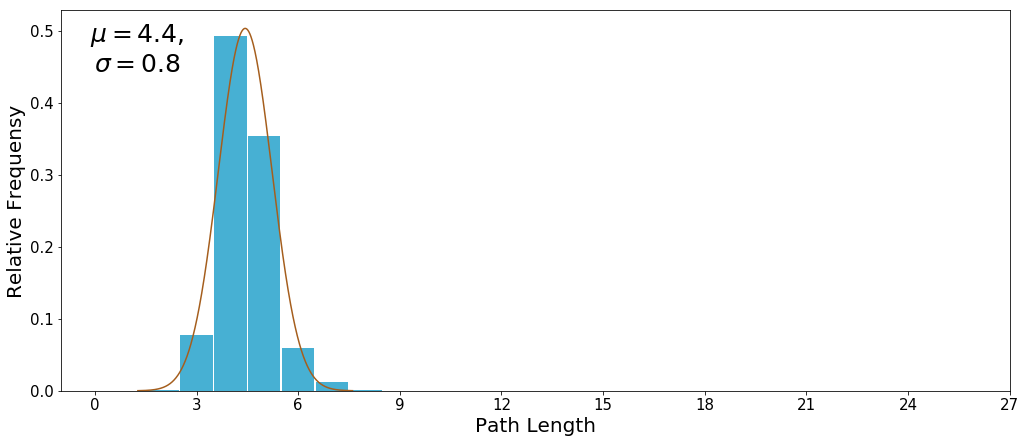

In [9]:
draw_histogram('en')

We have however ignored all pairs which do not have any path inbetween them. It would be interesting to see how likely it is to select a pair with no path between. Once again we use our function with `'en'` as the parameter to display this information.

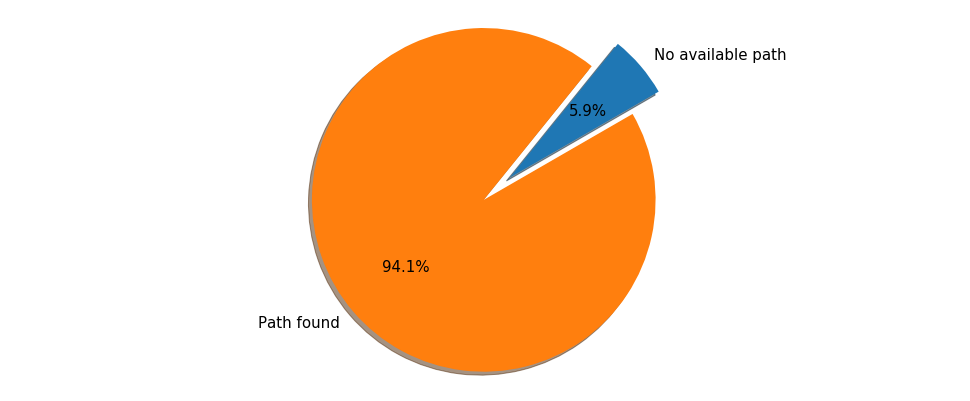

In [10]:
draw_pie_chart('en')

#### 3.1.1. Longest Path #### 

Another point of intrest is the longest path found so far. The longest path found so far is between the following two articles:

In [11]:
longest_path = get_longest_path('en')
longest_path

Longest Path: 27
'Xihua' -> 'Billboard Top Hits: 1988'


['Xihua',
 'Xihua County',
 'Time zone',
 'Illinois',
 'Soul music',
 'Dan Penn',
 'Cry Like a Baby',
 "Billboard Top Rock'n'Roll Hits: 1968",
 "Billboard Top Rock'n'Roll Hits: 1969",
 "Billboard Top Rock'n'Roll Hits: 1970",
 "Billboard Top Rock'n'Roll Hits: 1971",
 "Billboard Top Rock'n'Roll Hits: 1972",
 "Billboard Top Rock'n'Roll Hits: 1973",
 "Billboard Top Rock'n'Roll Hits: 1974",
 'Billboard Top Hits: 1975',
 'Billboard Top Hits: 1976',
 'Billboard Top Hits: 1977',
 'Billboard Top Hits: 1978',
 'Billboard Top Hits: 1979',
 'Billboard Top Hits: 1980',
 'Billboard Top Hits: 1981',
 'Billboard Top Hits: 1982',
 'Billboard Top Hits: 1983',
 'Billboard Top Hits: 1984',
 'Billboard Top Hits: 1985',
 'Billboard Top Hits: 1986',
 'Billboard Top Hits: 1987',
 'Billboard Top Hits: 1988']

### 3.2. Swedish Wikipedia ###

In [12]:
pprint_pairs('sv')

Pairs analyzed in the 'sv' database: 216,000


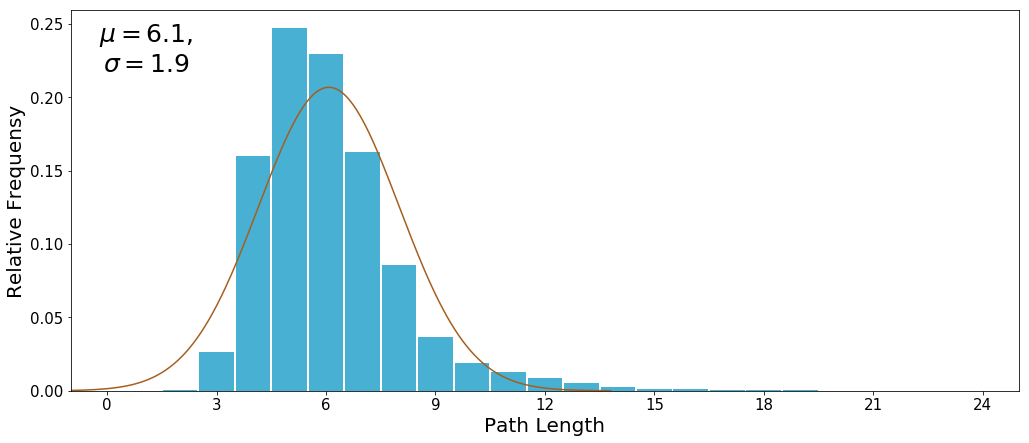

In [13]:
draw_histogram('sv')

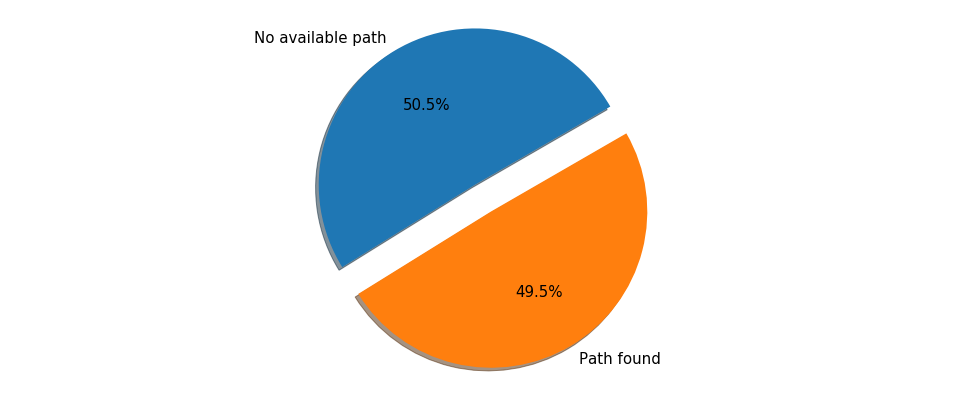

In [14]:
draw_pie_chart('sv')

#### 3.2.1. Longest Path ####

In [15]:
longest_path = get_longest_path('sv')
longest_path

Longest Path: 25
'Keizanchin' -> 'Kharah-ye Zard (berg i Ghowr, lat 34,38, long 64,60)'


['Keizanchin',
 'Hyesan',
 '1915',
 '3 februari',
 '2016',
 'Istanbul Atatürks flygplats',
 'Orumieh (flygplats i Iran)',
 'Kūh-e Sīāh (berg i Västazarbaijan, lat 37,69, long 44,87)',
 'Kūh-e Sīāh',
 'Kūh-e Sīāh (berg i Mazandaran, lat 36,14, long 52,14)',
 'Noj',
 'Kūh-e Sar Posht',
 'Kūh-e Cheshmeh Kenār',
 'Kūh-e Nāz̧er',
 'Reshteh-ye Alborz (bergskedja i Mazandaran)',
 'Kūh-e Kabūd (berg i Mazandaran)',
 'Kūh-e Kabūd',
 'Kūh-e Kabūd (kulle)',
 'Garm Āb (ort)',
 'Garm Āb',
 'Cheshmeh-ye Garmāb (källa i Iran)',
 'Cheshmeh-ye Garmāb',
 'Chashmah-ye Garm Āb (källa i Herat)',
 'Kharah-ye Zard (berg i Herat)',
 'Kharah-ye Zard',
 'Kharah-ye Zard (berg i Ghowr, lat 34,38, long 64,60)']

### 3.3. German Wikipedia ###

In [16]:
pprint_pairs('de')

Pairs analyzed in the 'de' database: 202,000


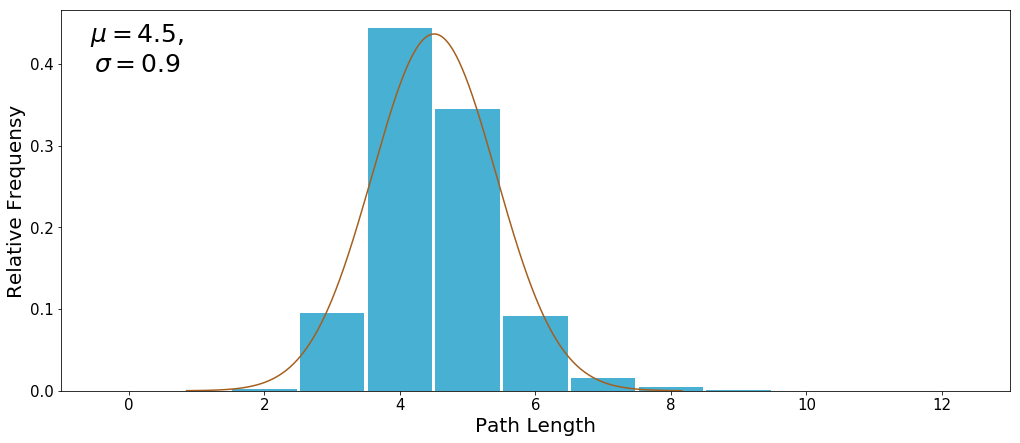

In [17]:
draw_histogram('de')

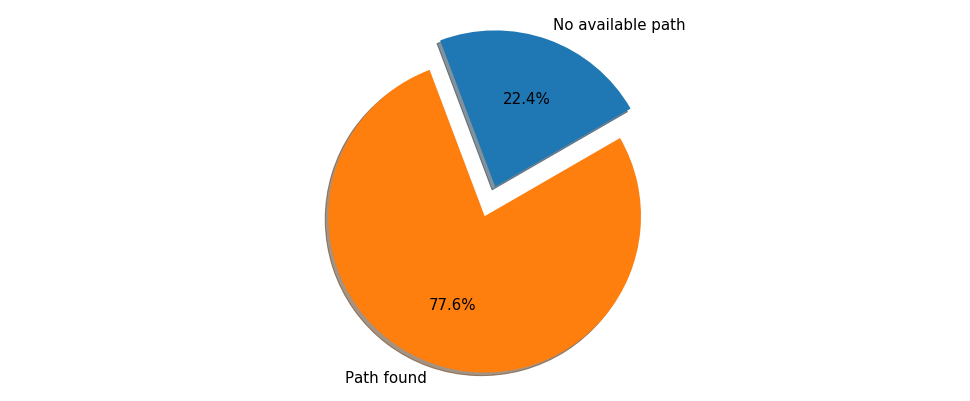

In [18]:
draw_pie_chart('de')

#### 3.3.1. Longest Path ####

In [19]:
longest_path = get_longest_path('de')
longest_path

Longest Path: 13
'Beim Wolfi' -> 'Marceau Bay Gutter'


['Beim Wolfi',
 'Baudenkmal',
 'Politisches System der Bundesrepublik Deutschland',
 'Liste der Regierungssysteme nach Staat',
 'Dominica',
 'Indian River (Dominica)',
 'Barry River (Dominica)',
 'North River (Dominica)',
 'Bell Hall River',
 'Salt River (Dominica)',
 'Manicou River',
 'Lamothe River',
 'Clifton River (Dominica)',
 'Marceau Bay Gutter']

### 3.4. Frensh Wikipedia ###

In [20]:
pprint_pairs('fr')

Pairs analyzed in the 'fr' database: 213,000


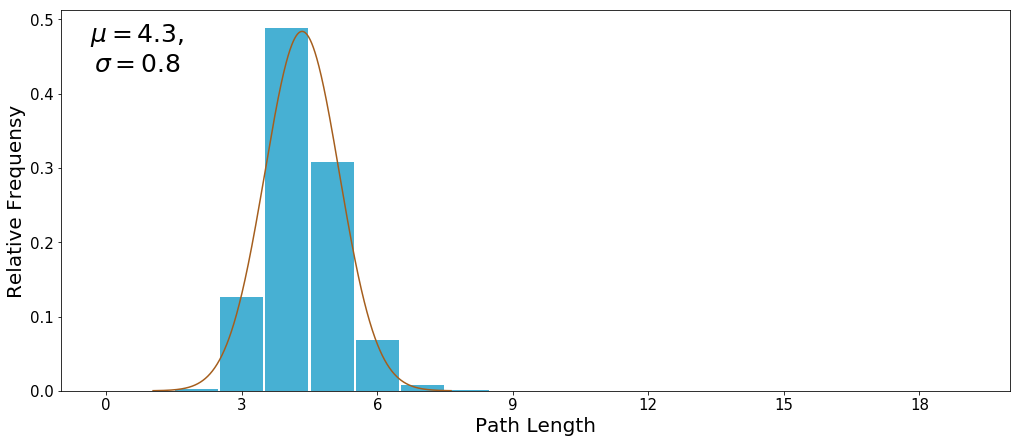

In [21]:
draw_histogram('fr')

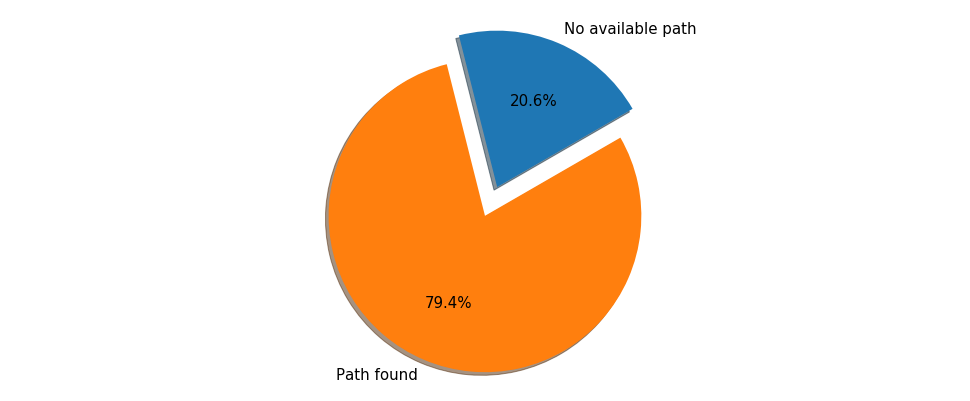

In [22]:
draw_pie_chart('fr')

#### 3.4.1. Longest Path ####

In [23]:
longest_path = get_longest_path('fr')
longest_path

Longest Path: 20
'Criocère' -> 'Gouvernement Manuel García Prieto (1)'


['Criocère',
 'Français',
 'Nouveau-Brunswick',
 '2009',
 '2009 à Madagascar',
 'Directoire militaire',
 'Gouvernement Manuel García Prieto (5)',
 'Gouvernement José Sánchez Guerra',
 'Gouvernement Antonio Maura (5)',
 'Gouvernement Manuel Allendesalazar Muñoz de Salazar (2)',
 'Gouvernement Gabino Bugallal Araújo',
 'Gouvernement Eduardo Dato (3)',
 'Gouvernement Manuel Allendesalazar Muñoz de Salazar (1)',
 'Gouvernement Joaquín Sánchez de Toca',
 'Gouvernement Antonio Maura (4)',
 'Gouvernement Álvaro Figueroa y Torres Mendieta (4)',
 'Gouvernement Manuel García Prieto (4)',
 'Gouvernement Antonio Maura (3)',
 'Gouvernement Manuel García Prieto (3)',
 'Gouvernement Eduardo Dato (2)',
 'Gouvernement Manuel García Prieto (1)']